# Only Plotting

In [1]:
import os

import torch

# Import our module containing helper functions
import gravann.output as plotter
from gravann.input import sample_reader
from gravann.labels import calculate_density
from gravann.network import encodings, network_initalizer, layers
from gravann.training import validator, compute_c_for_model
from gravann.util import enableCUDA, fixRandomSeeds

# plotting stuff
%matplotlib notebook

# Ensure that changes in imported module (gravann most importantly) are autoreloaded
%load_ext autoreload
%autoreload 2

# If possible enable CUDA
enableCUDA()
fixRandomSeeds()
device = os.environ["TORCH_DEVICE"]
print("Will use device ", device)

C:\Users\josch\miniconda3\envs\geodesynet\lib\site-packages\pyvista\themes.py:131: PyVistaDeprecationWarning: use "dark" instead of "night" theme
  warnings.warn('use "dark" instead of "night" theme', PyVistaDeprecationWarning)


Available devices  1
__pyTorch VERSION: 1.13.1
__CUDNN VERSION: 8500
__Number CUDA Devices: 1
Active CUDA Device: GPU 0
Setting default tensor type to Float32
Will use device  cuda:0


We first chose one of the following samples:

    "eros", "bennu", "itokawa", "churyumov-gerasimenko", "planetesimal", "torus", "bennu_nu", "itokawa_nu", "planetesimal_nu"

In [2]:
##################### PLEASE SPECIFY THIS ####################
# one of "eros", "bennu", "itokawa", "churyumov-gerasimenko", "planetesimal", "torus", "bennu_nu", "itokawa_nu", "planetesimal_nu"
SAMPLE_NAME = "eros"
# can be freely chosen
MODEL_NAME = "first"

N_QUADRATUR = 10000

# Plotting
NUMBER_OF_POINTS_FOR_COMPARISON = 1000

# Real Math Stuff
NUMBER_OF_POINTS_FOR_VALIDATION = 10000

BATCH_SIZE = 100
##############################################################

MODEL_FILENAME_MASCON = f"models_polyhedral/{SAMPLE_NAME}_mascon_{MODEL_NAME}.mdl"
MODEL_FILENAME_POLYHEDRAL = f"models_polyhedral/{SAMPLE_NAME}_polyhedral_{MODEL_NAME}.mdl"

# Re-specify the encoding if another encoding was used for training!
encoding = encodings.DirectEncoding()

mesh_vertices, mesh_faces = sample_reader.load_polyhedral_mesh(SAMPLE_NAME)
density = calculate_density(mesh_vertices, mesh_faces)

# Only for the legacy plots required
mascon_points, mascon_masses = sample_reader.load_mascon_data(SAMPLE_NAME)

print(f"Chosen body: {SAMPLE_NAME}")
print(f"Loaded Polyhedral Mesh Data:")
print(f"Loaded the Mesh of {SAMPLE_NAME}")
print(f"Number of vertices: {len(mesh_vertices)}")
print(f"Number of faces (triangles): {len(mesh_faces)}")
print(f"Calculated Density: {density}")

Name of the chosen body:  eros
Loaded the Mesh of eros
Number of vertices: 7374
Number of faces (triangles): 14744
Calculated Density: 3.394506131751055


## 0 - Comparing polyhedral model & mascon model
Next, we can plot a comparison between the polyhedral gravity model's labels and the mascon labels:

Discarding 0 of 18294 points in altitude sampler which did not meet requested altitude.
Splitting in left / right hemisphere
Left:  471  points.
Right:  529  points.


<IPython.core.display.Javascript object>


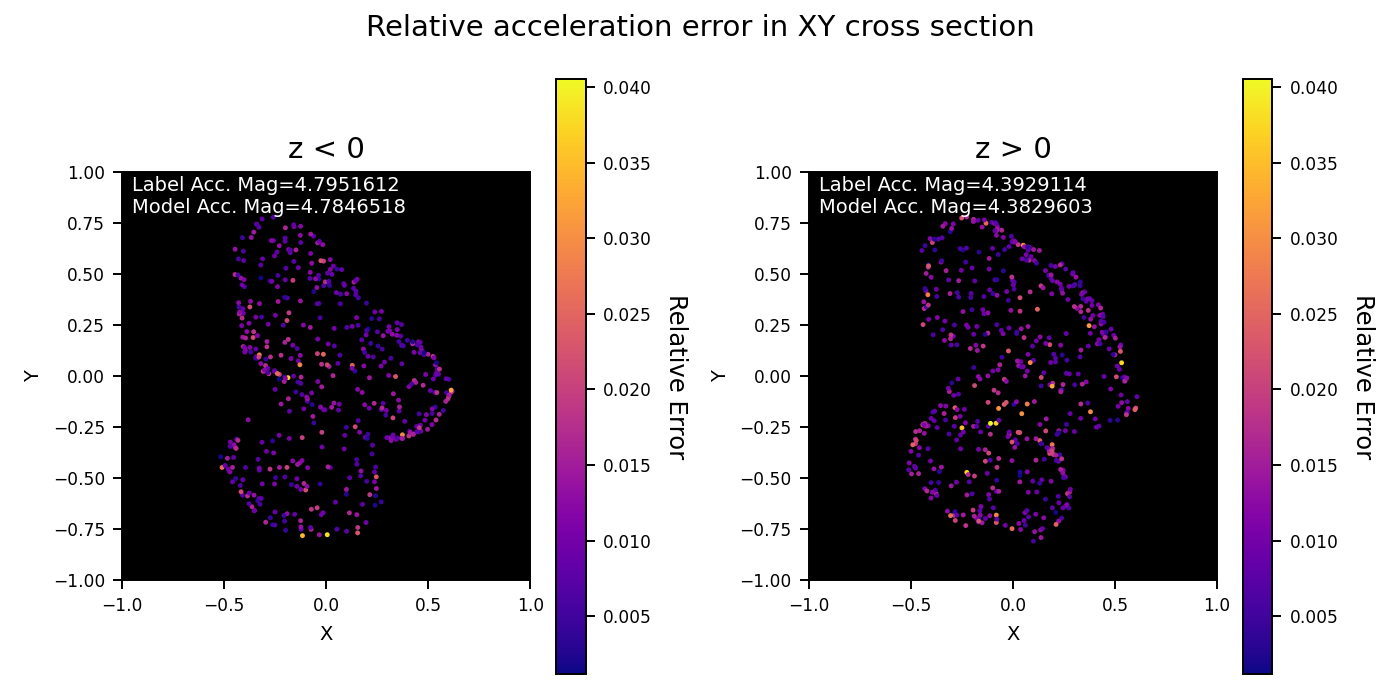

(<AxesSubplot: title={'center': 'z > 0'}, xlabel='X', ylabel='Y'>,
 tensor([[-2.6972, -1.7923, -0.1932],
         [-1.3476,  1.2703, -2.3604],
         [-2.7420, -0.7167, -1.5513],
         ...,
         [-0.7169,  1.4857, -2.2063],
         [-1.7116,  2.3669, -0.5743],
         [-2.4443, -1.6995, -1.0999]]))

In [6]:
plotter.plot_compare_acceleration(SAMPLE_NAME,
                                  compare_mode=('mascon', 'polyhedral'),
                                  plane="XY",
                                  N=NUMBER_OF_POINTS_FOR_COMPARISON,
                                  logscale=False,
                                  altitude=1e-5)

## 1 - Loading the models

In [3]:
# POLYHEDRAL MODEL
polyhedral_model = network_initalizer.init_network(encoding, n_neurons=100, model_type="siren",
                                                   activation=layers.AbsLayer())

polyhedral_model.load_state_dict(torch.load(MODEL_FILENAME_POLYHEDRAL))

polyhedral_c = compute_c_for_model(polyhedral_model, encoding, 'polyhedral',
                                   mascon_points=mascon_points,
                                   mascon_masses=mascon_masses,
                                   mesh_vertices=mesh_vertices,
                                   mesh_faces=mesh_faces,
                                   density=density,
                                   use_acc=True)
plotter.plot_model_rejection(polyhedral_model, encoding, views_2d=True, bw=True, N=NUMBER_OF_POINTS_FOR_COMPARISON,
                             alpha=0.1, s=50, c=polyhedral_c, crop_p=0.1, progressbar=True)

C:\Users\josch\miniconda3\envs\geodesynet\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
# MASCON MODEL
mascon_model = network_initalizer.init_network(encoding, n_neurons=100, model_type="siren",
                                               activation=layers.AbsLayer())

mascon_model.load_state_dict(torch.load(MODEL_FILENAME_MASCON))

mascon_c = compute_c_for_model(mascon_model, encoding, 'mascon',
                               mascon_points=mascon_points,
                               mascon_masses=mascon_masses,
                               mesh_vertices=mesh_vertices,
                               mesh_faces=mesh_faces,
                               density=density,
                               use_acc=True)
plotter.plot_model_rejection(mascon_model, encoding, views_2d=True, bw=True, N=NUMBER_OF_POINTS_FOR_COMPARISON,
                             alpha=0.1, s=50, c=mascon_c, crop_p=0.1, progressbar=True)

## 2 - Comparing Polyhedral Model to the Polyhedral Ground Truth

Discarding 0 of 14744 points in altitude sampler which did not meet requested altitude.
Splitting in left / right hemisphere
Left:  471  points.
Right:  529  points.


<IPython.core.display.Javascript object>


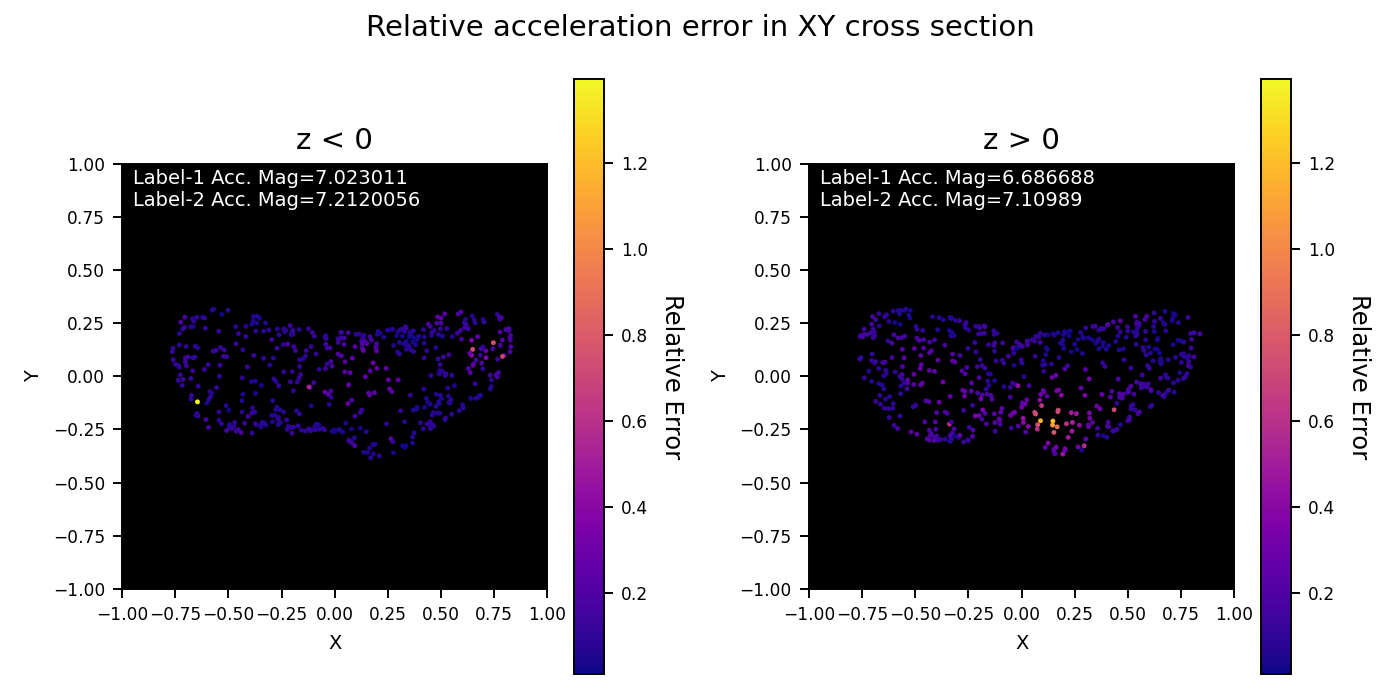

(<AxesSubplot: title={'center': 'z > 0'}, xlabel='X', ylabel='Y'>,
 tensor([[-0.4325, -2.5441, -4.1091],
         [ 3.6912,  3.2976, -1.3601],
         [-3.8082,  1.6421, -2.0800],
         ...,
         [-2.3403, -3.2841, -1.4673],
         [-0.6040, -2.5914, -4.3121],
         [-0.3400, -1.9690, -4.7597]]))

In [4]:
plotter.polyhedral.plot_compare_acceleration(SAMPLE_NAME,
                                             compare_mode=('model', 'polyhedral'),
                                             model_1=(polyhedral_model, encoding, polyhedral_c),
                                             plane="XY",
                                             N=NUMBER_OF_POINTS_FOR_COMPARISON,
                                             logscale=False,
                                             altitude=1e-5)

In [5]:
polyhedral_model2polyhedral_gt = validator.validate(polyhedral_model, encoding, SAMPLE_NAME, 'polyhedral', use_acc=True,
                                                    mesh_vertices=mesh_vertices,
                                                    mesh_faces=mesh_faces,
                                                    N=NUMBER_OF_POINTS_FOR_VALIDATION,
                                                    N_integration=N_QUADRATUR,
                                                    batch_size=BATCH_SIZE,
                                                    progressbar=True)

Computing validation...:  60%|█████████████████████████████▊                    | 44300/74244 [01:39<01:06, 447.16it/s]

Discarding 4193 of 14744 points in altitude sampler which did not meet requested altitude.


Computing validation...:  73%|████████████████████████████████████▋             | 54400/74244 [02:17<00:45, 440.32it/s]

Discarding 7421 of 14744 points in altitude sampler which did not meet requested altitude.


Computing validation...:  87%|███████████████████████████████████████████▎      | 64400/74244 [02:51<00:23, 424.73it/s]

Discarding 11243 of 14744 points in altitude sampler which did not meet requested altitude.


Computing validation...: 74400it [03:21, 368.95it/s]                                                                   


In [ ]:
polyhedral_model2polyhedral_gt

## 3 - Comparing Polyhedral Model to the Mascon Ground Truth

In [7]:
polyhedral_model2mascon_gt = validator.validate(polyhedral_model, encoding, SAMPLE_NAME, 'mascon', use_acc=True,
                                                mascon_points=mascon_points,
                                                mascon_masses=mascon_masses,
                                                N=NUMBER_OF_POINTS_FOR_VALIDATION,
                                                N_integration=N_QUADRATUR,
                                                batch_size=BATCH_SIZE,
                                                progressbar=True)

Computing validation...:  60%|█████████████████████████████▏                   | 44300/74244 [00:41<00:28, 1059.81it/s]

Discarding 4193 of 14744 points in altitude sampler which did not meet requested altitude.


Computing validation...:  73%|███████████████████████████████████▉             | 54400/74244 [01:06<00:19, 1013.03it/s]

Discarding 7421 of 14744 points in altitude sampler which did not meet requested altitude.


Computing validation...:  87%|██████████████████████████████████████████▍      | 64300/74244 [01:26<00:09, 1014.01it/s]

Discarding 11243 of 14744 points in altitude sampler which did not meet requested altitude.


Computing validation...: 74400it [01:42, 723.09it/s]                                                                   


In [8]:
polyhedral_model2mascon_gt

,Altitude,Normalized L1 Loss,Normalized Relative Component Loss,RMSE,relRMSE
0,Low Altitude,0.400965,0.265435,2.400736,0.502057
1,High Altitude,0.140413,0.106901,0.900942,0.209399
2,Altitude_0,0.153224,0.115225,0.642476,0.157618
3,Altitude_1,0.073440,0.066825,0.277698,0.082726
4,Altitude_2,0.016126,0.024948,0.062350,0.031864


## 4 - Comparing Mascon Model to the Mascon Ground Truth

In [14]:
mascon_model2mascon_gt = validator.validate(mascon_model, encoding, SAMPLE_NAME, 'mascon', use_acc=True,
                                            mascon_points=mascon_points,
                                            mascon_masses=mascon_masses,
                                            N=NUMBER_OF_POINTS_FOR_VALIDATION,
                                            N_integration=N_QUADRATUR,
                                            batch_size=BATCH_SIZE,
                                            progressbar=True)

Computing validation...:  60%|█████████████████████████████▊                    | 44300/74244 [01:40<01:06, 448.39it/s]

Discarding 4193 of 14744 points in altitude sampler which did not meet requested altitude.


Computing validation...:  73%|████████████████████████████████████▋             | 54400/74244 [02:17<00:47, 420.56it/s]

Discarding 7421 of 14744 points in altitude sampler which did not meet requested altitude.


Computing validation...:  87%|███████████████████████████████████████████▎      | 64400/74244 [02:52<00:22, 433.90it/s]

Discarding 11243 of 14744 points in altitude sampler which did not meet requested altitude.


Computing validation...: 74400it [03:21, 368.37it/s]                                                                   


In [15]:
mascon_model2mascon_gt

,Altitude,Normalized L1 Loss,Normalized Relative Component Loss,RMSE,relRMSE
0,Low Altitude,0.513921,0.342901,2.971832,0.639112
1,High Altitude,0.107922,0.082616,0.698949,0.167989
2,Altitude_0,0.108737,0.082717,0.465566,0.117454
3,Altitude_1,0.042256,0.039058,0.153655,0.047069
4,Altitude_2,0.009114,0.014295,0.034887,0.018536


## 5 - Comparing Mascon Model to the Polyhedral Ground Truth

In [ ]:
plotter.plot_compare_acceleration(SAMPLE_NAME,
                                  compare_mode=('model', 'polyhedral'),
                                  model_1=(mascon_model, encoding, mascon_c),
                                  plane="XY",
                                  N=NUMBER_OF_POINTS_FOR_COMPARISON,
                                  logscale=False,
                                  altitude=1e-5)

In [16]:
mascon_model2polyhedral_gt = validator.validate(mascon_model, encoding, SAMPLE_NAME, 'polyhedral', use_acc=True,
                                                mesh_vertices=mesh_vertices,
                                                mesh_faces=mesh_faces,
                                                N=NUMBER_OF_POINTS_FOR_VALIDATION,
                                                N_integration=N_QUADRATUR,
                                                batch_size=BATCH_SIZE,
                                                progressbar=True)

Computing validation...:  60%|█████████████████████████████▎                   | 44400/74244 [00:42<00:25, 1177.09it/s]

Discarding 4193 of 14744 points in altitude sampler which did not meet requested altitude.


Computing validation...:  73%|███████████████████████████████████▊             | 54300/74244 [01:06<00:19, 1010.97it/s]

Discarding 7421 of 14744 points in altitude sampler which did not meet requested altitude.


Computing validation...:  87%|███████████████████████████████████████████▎      | 64400/74244 [01:27<00:10, 908.21it/s]

Discarding 11243 of 14744 points in altitude sampler which did not meet requested altitude.


Computing validation...: 74400it [01:44, 713.01it/s]                                                                   


In [17]:
mascon_model2polyhedral_gt

,Altitude,Normalized L1 Loss,Normalized Relative Component Loss,RMSE,relRMSE
0,Low Altitude,0.513411,0.343971,2.963008,0.642469
1,High Altitude,0.107987,0.082732,0.699187,0.168404
2,Altitude_0,0.110591,0.084046,0.471066,0.118622
3,Altitude_1,0.042011,0.038850,0.150406,0.046198
4,Altitude_2,0.009021,0.014206,0.035407,0.018843


## 6 - Comparing polyhedral trained NN & mascon trained NN

Discarding 0 of 14744 points in altitude sampler which did not meet requested altitude.
Splitting in left / right hemisphere
Left:  456  points.
Right:  544  points.


<IPython.core.display.Javascript object>


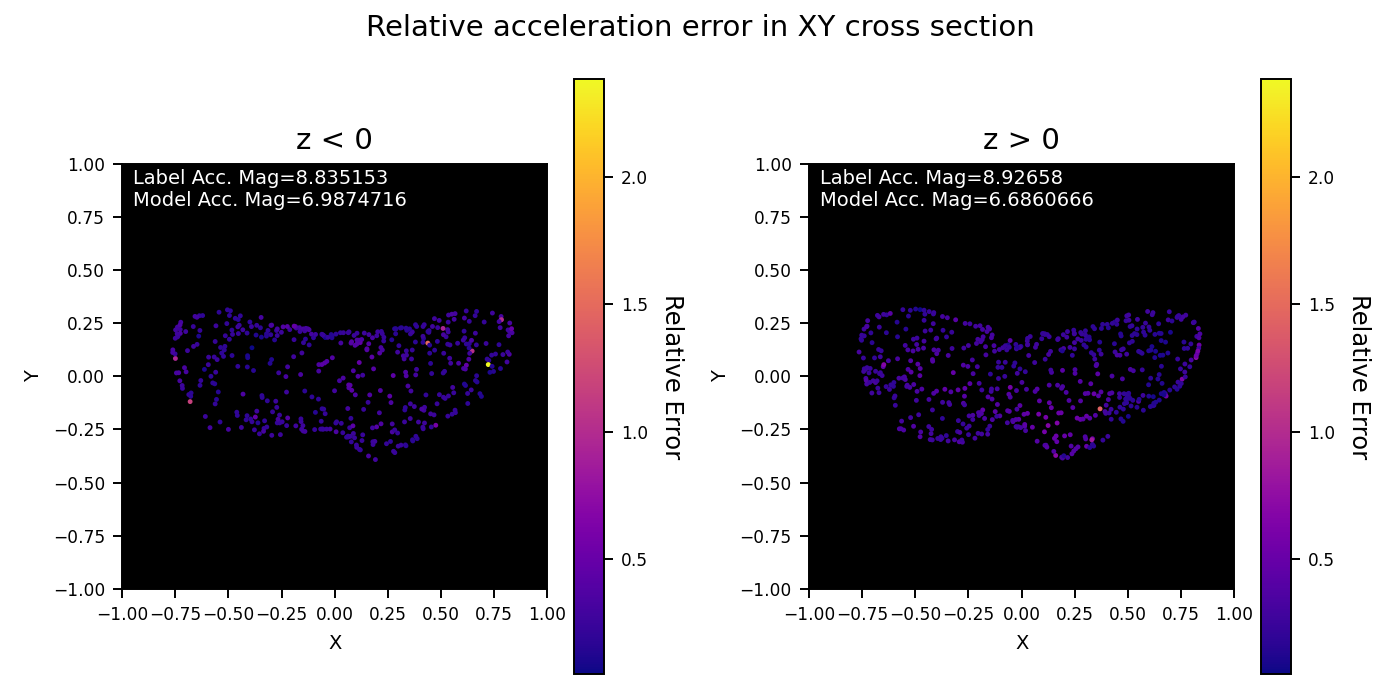

(<AxesSubplot: title={'center': 'z > 0'}, xlabel='X', ylabel='Y'>,
 tensor([[ -2.0665,   4.0766,  -4.8118],
         [ -0.3770,  -5.5343,  -1.8547],
         [  1.7699,  -3.2762,  -3.8521],
         ...,
         [  4.2000,   0.1821,  -4.3430],
         [  3.1874,  -2.2677, -10.5809],
         [  0.1086,   5.3690,  -2.4070]]))

In [21]:
plotter.plot_compare_acceleration(SAMPLE_NAME,
                                  compare_mode=('model', 'model'),
                                  model_1=(mascon_model, encoding, mascon_c),
                                  model_2=(polyhedral_model, encoding, polyhedral_c),
                                  plane="XY",
                                  N=NUMBER_OF_POINTS_FOR_COMPARISON,
                                  logscale=False,
                                  altitude=1e-5)